Run this notebook to

- Merge all stimulus epochs from all participants and all sessions and save merged epochs file
- Plot P3 for correct vs incorrect trials
- Plot P3 for correct vs incorrect trials split by partner condition
- Plot P3 for lower than median vs higher than median confidence 
- Plot P3 for lower than median vs higher than median confidence split by partner condition
- Plot all of the above separately for the strategic and observational conditions


## Import stuff

In [1]:
import os
import numpy as np
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

million = 1000000.


#%matplotlib qt
%matplotlib inline

input_dir = 'TaskstimulusEpochsMastoids'


In [2]:
def load_subj_eeg(path, file, downsample=None):
    fp = os.path.join(path, '%s-epo.fif' % file)
    print('>>> Loading %s' % fp)
    epochs = mne.read_epochs(fp, preload=True)
    if downsample is not None:
        epochs = epochs.resample(downsample)
    return epochs

def load_all_eeg(path, files, downsample=None):
    subject_epochs = [load_subj_eeg(path, file, downsample=downsample) for file in files]
    epochs = mne.epochs.concatenate_epochs(subject_epochs)
    return epochs

## Merge epochs

In [3]:
participant_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]

sessions = [1, 2]

participant_files = []

for session in sessions:
    for subject in participant_numbers:
        participant_files.append('%i_%i' % (subject, session))

In [4]:
remerge = False
if remerge:
    stimulus_epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    stimulus_epochs.save('mergedData/stimulus_epoch_mastoids-epo.fif', overwrite=True)
else:
    stimulus_epochs = mne.read_epochs('mergedData/stimulus_epoch_mastoids-epo.fif')
    
stimulus_epochs = stimulus_epochs.pick_types(eeg=True)
data = stimulus_epochs.metadata

Reading C:\Users\majaf\Desktop\Google Drive\PhD\Study 5 Confidence Matching with EEG (A)\Data Analysis\mergedData\stimulus_epoch_mastoids-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 50 columns
11741 matching events found
No baseline correction applied
0 projection items activated


In [13]:
roi = ["Pz", "CPz", "POz", "P1", "P2"]

In [5]:
def plot_joint(erp, times, title='', width=12, height=8, invert=True, save=None):
    fig = erp.plot_joint(times=times,
                         show=False,
                         ts_args=dict(time_unit='s'),
                         topomap_args=dict(res=128, contours=4, time_unit='s'),
                         title=title)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    axes = fig.get_axes()
    ax0 = axes[0]
    if invert:
        ax0.invert_yaxis()
    ch = ax0.get_children()
    for c in ch:
        if type(c) == plt.Annotation:
            c.remove()
        if type(c) == plt.Line2D:
            c.set_linewidth(2.5)
            c.set_alpha(.75)
    leg_ax = axes[-2]
    leg_ax.get_children()[0].set_sizes([50.])
    leg_ax.set_aspect('equal')
    if save is not None:
        fig.savefig(save)
    fig.show()


No projector specified for this dataset. Please consider the method self.add_proj.


C:\Users\majaf\AppData\Local\Temp\ipykernel_12664\56482209.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


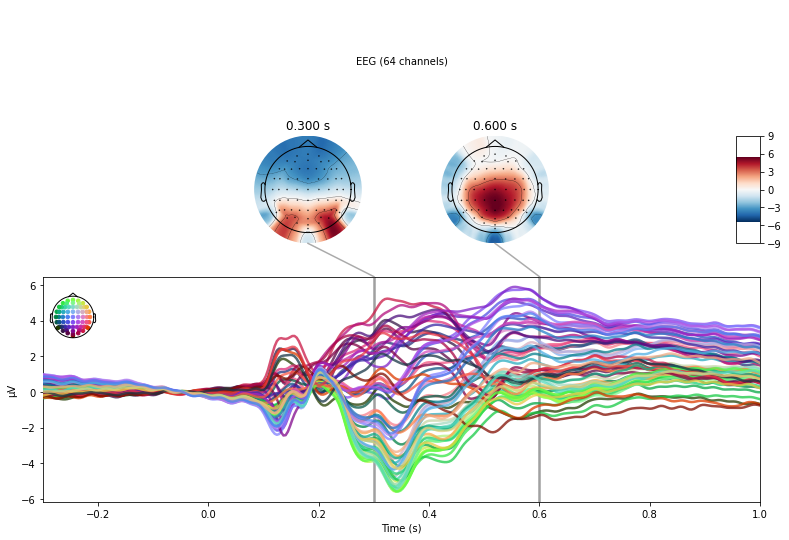

In [13]:
erp = stimulus_epochs.copy().average()
plot_joint(erp, [0.3, 0.6], invert=False)
plt.savefig('Figures/all channels.pdf')

## Correct vs incorrect grand average (first calculating each participant's average)

Identifying common channels ...
Identifying common channels ...


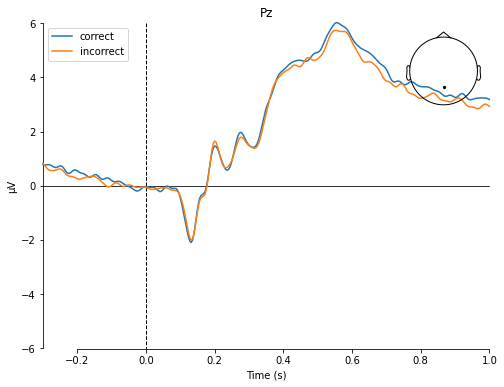

[<Figure size 576x432 with 2 Axes>]

In [14]:
grand_average_correct = []
grand_average_incorrect = []

correct_epochs = stimulus_epochs['participant_correct == True']
incorrect_epochs = stimulus_epochs['participant_correct == False']

for subject in participant_numbers:
    grand_average_correct.append(correct_epochs['participant == %i' % subject].average())
    grand_average_incorrect.append(incorrect_epochs['participant == %i' % subject].average())


grand_average_correct = mne.grand_average(grand_average_correct)
grand_average_incorrect = mne.grand_average(grand_average_incorrect)

evokeds = dict(correct=grand_average_correct,
               incorrect=grand_average_incorrect)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Correct vs incorrect split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


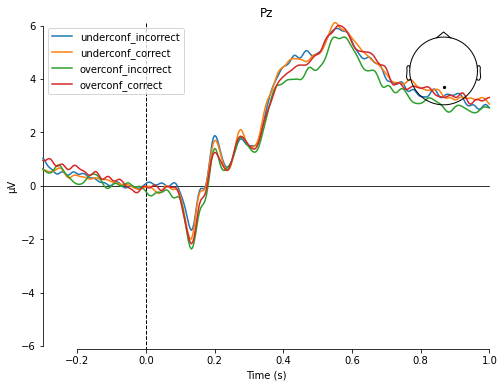

[<Figure size 576x432 with 2 Axes>]

In [15]:
grand_average_underconf_correct = []
grand_average_underconf_incorrect = []
grand_average_overconf_correct = []
grand_average_overconf_incorrect = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_correct_epochs = underconf_epochs['participant_correct == True']
underconf_incorrect_epochs = underconf_epochs['participant_correct == False']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_correct_epochs = overconf_epochs['participant_correct == True']
overconf_incorrect_epochs = overconf_epochs['participant_correct == False']



for subject in participant_numbers:    
    grand_average_underconf_correct.append(underconf_correct_epochs['participant == %i' % subject].average())
    grand_average_underconf_incorrect.append(underconf_incorrect_epochs['participant == %i' % subject].average())
    grand_average_overconf_correct.append(overconf_correct_epochs['participant == %i' % subject].average())
    grand_average_overconf_incorrect.append(overconf_incorrect_epochs['participant == %i' % subject].average())

grand_average_underconf_correct = mne.grand_average(grand_average_underconf_correct)
grand_average_underconf_incorrect = mne.grand_average(grand_average_underconf_incorrect)
grand_average_overconf_correct = mne.grand_average(grand_average_overconf_correct)
grand_average_overconf_incorrect = mne.grand_average(grand_average_overconf_incorrect)


evokeds = dict(underconf_incorrect=grand_average_underconf_incorrect,
               underconf_correct=grand_average_underconf_correct,
               overconf_incorrect=grand_average_overconf_incorrect,
               overconf_correct=grand_average_overconf_correct)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Low vs high confidence grand average 

In [16]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
stimulus_epochs.metadata['confidence_z_by_participant'] = stimulus_epochs.metadata['participant_confidence'].groupby(stimulus_epochs.metadata['participant']).transform(zscore)
        
median_confidence = stimulus_epochs.metadata['confidence_z_by_participant'].median()


Identifying common channels ...
Identifying common channels ...


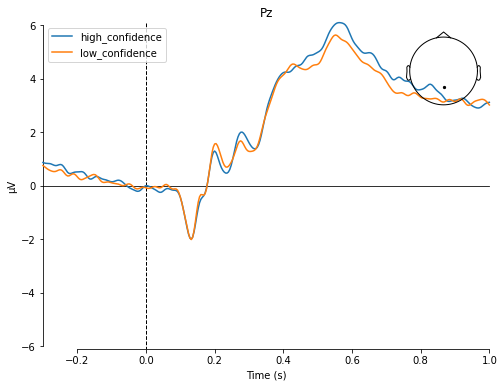

[<Figure size 576x432 with 2 Axes>]

In [17]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = stimulus_epochs['confidence_z_by_participant > 0']
low_conf_epochs = stimulus_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


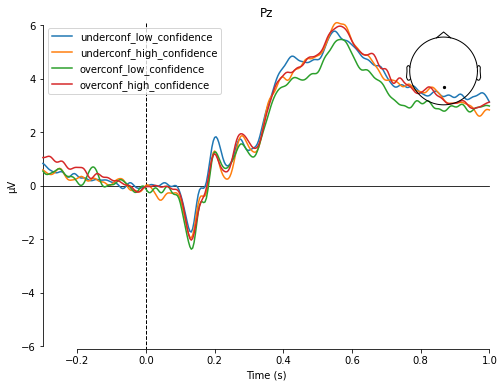

[<Figure size 576x432 with 2 Axes>]

In [18]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


In [6]:
stimulus_epochs_copy = stimulus_epochs

# Strategic condition

In [31]:
stimulus_epochs = stimulus_epochs_copy['condition == "s"']

## Correct vs incorrect grand average (first calculating each participant's average)

Identifying common channels ...
Identifying common channels ...


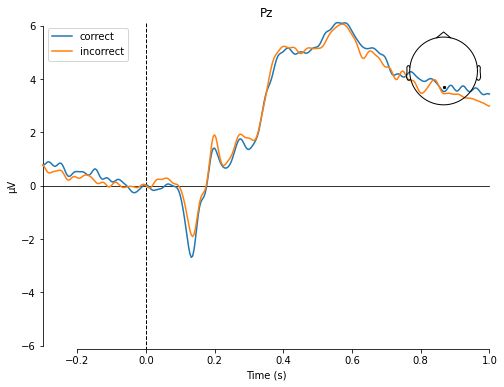

[<Figure size 576x432 with 2 Axes>]

In [9]:
grand_average_correct = []
grand_average_incorrect = []

correct_epochs = stimulus_epochs['participant_correct == True']
incorrect_epochs = stimulus_epochs['participant_correct == False']

for subject in participant_numbers:
    grand_average_correct.append(correct_epochs['participant == %i' % subject].average())
    grand_average_incorrect.append(incorrect_epochs['participant == %i' % subject].average())


grand_average_correct = mne.grand_average(grand_average_correct)
grand_average_incorrect = mne.grand_average(grand_average_incorrect)

evokeds = dict(correct=grand_average_correct,
               incorrect=grand_average_incorrect)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Correct vs incorrect split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


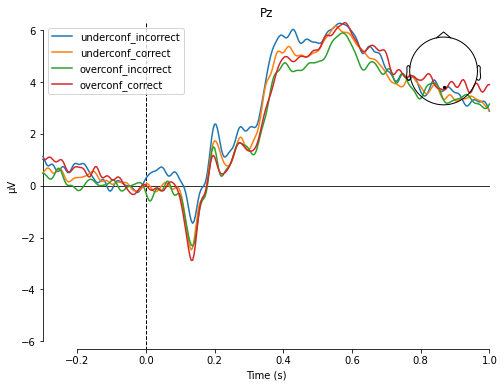

[<Figure size 576x432 with 2 Axes>]

In [10]:
grand_average_underconf_correct = []
grand_average_underconf_incorrect = []
grand_average_overconf_correct = []
grand_average_overconf_incorrect = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_correct_epochs = underconf_epochs['participant_correct == True']
underconf_incorrect_epochs = underconf_epochs['participant_correct == False']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_correct_epochs = overconf_epochs['participant_correct == True']
overconf_incorrect_epochs = overconf_epochs['participant_correct == False']



for subject in participant_numbers:    
    grand_average_underconf_correct.append(underconf_correct_epochs['participant == %i' % subject].average())
    grand_average_underconf_incorrect.append(underconf_incorrect_epochs['participant == %i' % subject].average())
    grand_average_overconf_correct.append(overconf_correct_epochs['participant == %i' % subject].average())
    grand_average_overconf_incorrect.append(overconf_incorrect_epochs['participant == %i' % subject].average())

grand_average_underconf_correct = mne.grand_average(grand_average_underconf_correct)
grand_average_underconf_incorrect = mne.grand_average(grand_average_underconf_incorrect)
grand_average_overconf_correct = mne.grand_average(grand_average_overconf_correct)
grand_average_overconf_incorrect = mne.grand_average(grand_average_overconf_incorrect)


evokeds = dict(underconf_incorrect=grand_average_underconf_incorrect,
               underconf_correct=grand_average_underconf_correct,
               overconf_incorrect=grand_average_overconf_incorrect,
               overconf_correct=grand_average_overconf_correct)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Underconfident vs overconfident partner

Identifying common channels ...
Identifying common channels ...


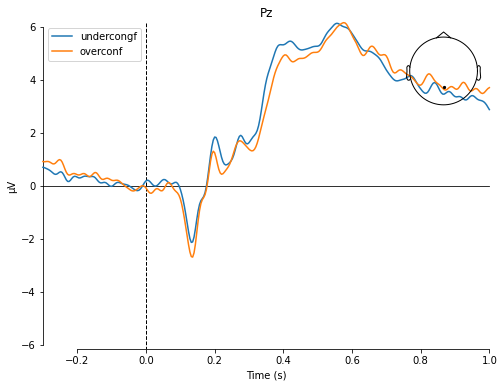

[<Figure size 576x432 with 2 Axes>]

In [11]:
grand_average_underconf = []
grand_average_overconf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
overconf_epochs = stimulus_epochs['partner == "overconfident"']

for subject in participant_numbers:
    grand_average_underconf.append(underconf_epochs['participant == %i' % subject].average())
    grand_average_overconf.append(overconf_epochs['participant == %i' % subject].average())


grand_average_underconf = mne.grand_average(grand_average_underconf)
grand_average_overconf = mne.grand_average(grand_average_overconf)

evokeds = dict(undercongf=grand_average_underconf,
               overconf=grand_average_overconf)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"


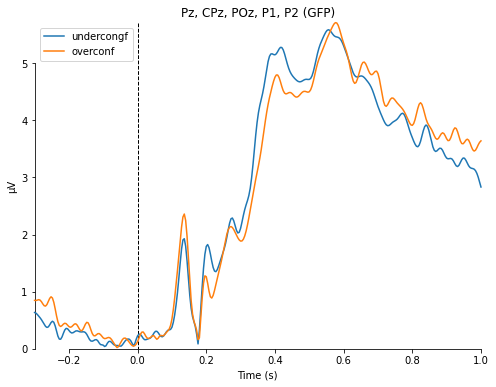

In [14]:
grand_average_underconf = []
grand_average_overconf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
overconf_epochs = stimulus_epochs['partner == "overconfident"']

for subject in participant_numbers:
    grand_average_underconf.append(underconf_epochs['participant == %i' % subject].average())
    grand_average_overconf.append(overconf_epochs['participant == %i' % subject].average())


grand_average_underconf = mne.grand_average(grand_average_underconf)
grand_average_overconf = mne.grand_average(grand_average_overconf)

evokeds = dict(undercongf=grand_average_underconf,
               overconf=grand_average_overconf)


fig = mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
fig[0].savefig('Figures/normative_partner.pdf', bbox_inches='tight')

## Low vs high confidence grand average 

In [32]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
stimulus_epochs.metadata['confidence_z_by_participant'] = stimulus_epochs.metadata['participant_confidence'].groupby(stimulus_epochs.metadata['participant']).transform(zscore)
        
median_confidence = stimulus_epochs.metadata['confidence_z_by_participant'].median()

# # then zscore by partner (check if this is okay to do like this!!!)
# stimulus_epochs.metadata['confidence_z_by_participant_by_partner'] = stimulus_epochs.metadata['confidence_z_by_participant'].groupby(stimulus_epochs.metadata['partner']).transform(zscore)


Identifying common channels ...
Identifying common channels ...


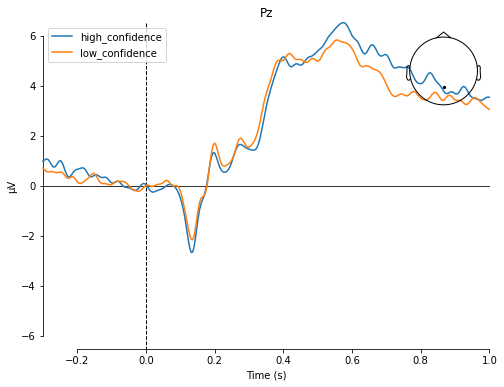

[<Figure size 576x432 with 2 Axes>]

In [16]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = stimulus_epochs['confidence_z_by_participant > 0']
low_conf_epochs = stimulus_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"


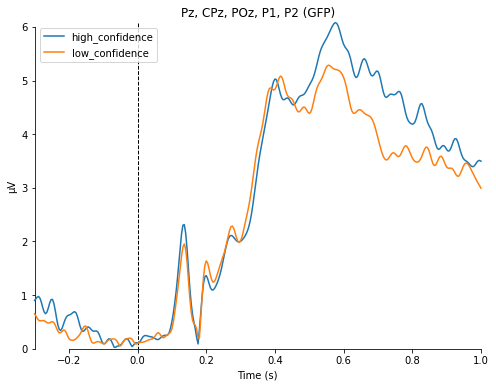

<Figure size 432x288 with 0 Axes>

In [17]:
roi = ["Pz", "CPz", "POz", "P1", "P2"]

grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = stimulus_epochs['confidence_z_by_participant > 0']
low_conf_epochs = stimulus_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
plt.savefig('Figures/normative_high_low_conf.pdf', bbox_inches='tight')

## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


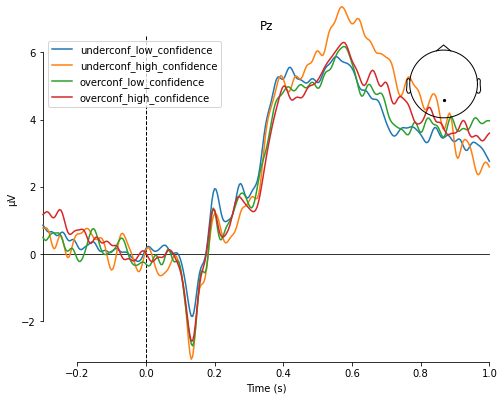

In [35]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

fig = mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False, ylim=dict(eeg=[-3.2, 6.5]))

fig[0].savefig('Figures/normative_high_low_conf_partner_Pz.pdf', bbox_inches='tight')

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


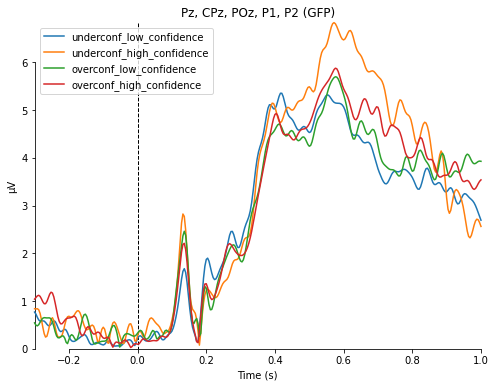

In [85]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)


fig = mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
fig[0].savefig('Figures/normative_high_low_conf_partner.pdf', bbox_inches='tight')

# Observational condition

In [22]:
stimulus_epochs = stimulus_epochs_copy['condition == "ns"']

## Correct vs incorrect grand average (first calculating each participant's average)

Identifying common channels ...
Identifying common channels ...


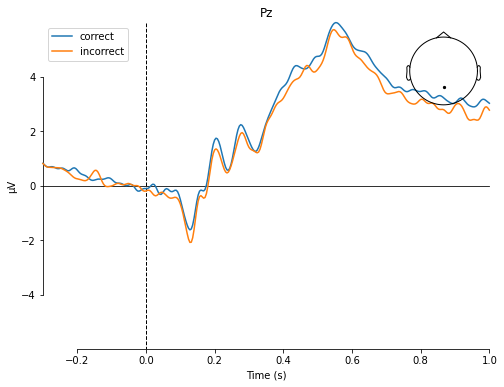

[<Figure size 576x432 with 2 Axes>]

In [23]:
grand_average_correct = []
grand_average_incorrect = []

correct_epochs = stimulus_epochs['participant_correct == True']
incorrect_epochs = stimulus_epochs['participant_correct == False']

for subject in participant_numbers:
    grand_average_correct.append(correct_epochs['participant == %i' % subject].average())
    grand_average_incorrect.append(incorrect_epochs['participant == %i' % subject].average())


grand_average_correct = mne.grand_average(grand_average_correct)
grand_average_incorrect = mne.grand_average(grand_average_incorrect)

evokeds = dict(correct=grand_average_correct,
               incorrect=grand_average_incorrect)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Correct vs incorrect split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


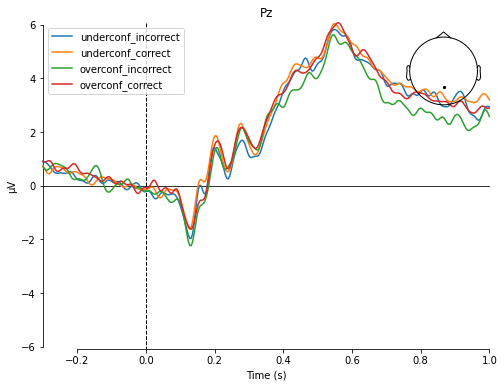

[<Figure size 576x432 with 2 Axes>]

In [88]:
grand_average_underconf_correct = []
grand_average_underconf_incorrect = []
grand_average_overconf_correct = []
grand_average_overconf_incorrect = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_correct_epochs = underconf_epochs['participant_correct == True']
underconf_incorrect_epochs = underconf_epochs['participant_correct == False']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_correct_epochs = overconf_epochs['participant_correct == True']
overconf_incorrect_epochs = overconf_epochs['participant_correct == False']



for subject in participant_numbers:    
    grand_average_underconf_correct.append(underconf_correct_epochs['participant == %i' % subject].average())
    grand_average_underconf_incorrect.append(underconf_incorrect_epochs['participant == %i' % subject].average())
    grand_average_overconf_correct.append(overconf_correct_epochs['participant == %i' % subject].average())
    grand_average_overconf_incorrect.append(overconf_incorrect_epochs['participant == %i' % subject].average())

grand_average_underconf_correct = mne.grand_average(grand_average_underconf_correct)
grand_average_underconf_incorrect = mne.grand_average(grand_average_underconf_incorrect)
grand_average_overconf_correct = mne.grand_average(grand_average_overconf_correct)
grand_average_overconf_incorrect = mne.grand_average(grand_average_overconf_incorrect)


evokeds = dict(underconf_incorrect=grand_average_underconf_incorrect,
               underconf_correct=grand_average_underconf_correct,
               overconf_incorrect=grand_average_overconf_incorrect,
               overconf_correct=grand_average_overconf_correct)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


## Underconfident vs overconfident partner

Identifying common channels ...
Identifying common channels ...


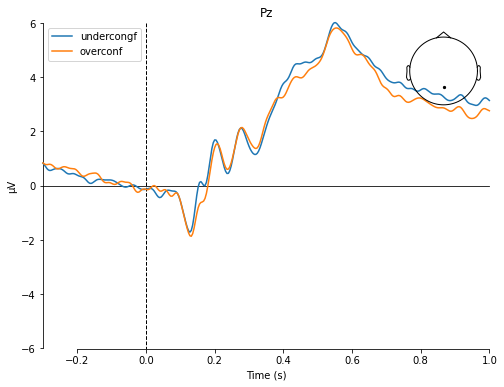

[<Figure size 576x432 with 2 Axes>]

In [108]:
grand_average_underconf = []
grand_average_overconf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
overconf_epochs = stimulus_epochs['partner == "overconfident"']

for subject in participant_numbers:
    grand_average_underconf.append(underconf_epochs['participant == %i' % subject].average())
    grand_average_overconf.append(overconf_epochs['participant == %i' % subject].average())


grand_average_underconf = mne.grand_average(grand_average_underconf)
grand_average_overconf = mne.grand_average(grand_average_overconf)

evokeds = dict(undercongf=grand_average_underconf,
               overconf=grand_average_overconf)


mne.viz.plot_compare_evokeds(evokeds, picks=["Pz"], invert_y=False)

Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"


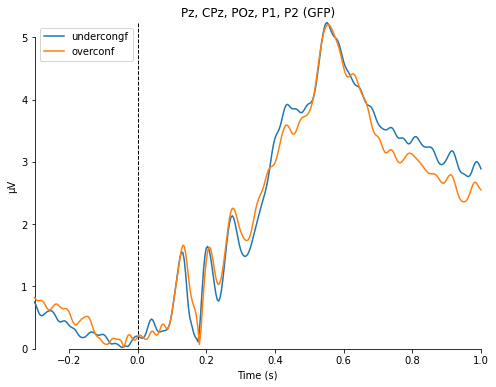

In [106]:
grand_average_underconf = []
grand_average_overconf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
overconf_epochs = stimulus_epochs['partner == "overconfident"']

for subject in participant_numbers:
    grand_average_underconf.append(underconf_epochs['participant == %i' % subject].average())
    grand_average_overconf.append(overconf_epochs['participant == %i' % subject].average())


grand_average_underconf = mne.grand_average(grand_average_underconf)
grand_average_overconf = mne.grand_average(grand_average_overconf)

evokeds = dict(undercongf=grand_average_underconf,
               overconf=grand_average_overconf)


fig = mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
fig[0].savefig('Figures/informational_partner.pdf', bbox_inches='tight')

## Low vs high confidence grand average 

In [25]:
zscore = lambda x: (x - x.mean()) / x.std()
# zscore by participant
stimulus_epochs.metadata['confidence_z_by_participant'] = stimulus_epochs.metadata['participant_confidence'].groupby(stimulus_epochs.metadata['participant']).transform(zscore)
        
median_confidence = stimulus_epochs.metadata['confidence_z_by_participant'].median()

# # then zscore by partner (check if this is okay to do like this!!!)
# stimulus_epochs.metadata['confidence_z_by_participant_by_partner'] = stimulus_epochs.metadata['confidence_z_by_participant'].groupby(stimulus_epochs.metadata['partner']).transform(zscore)


Identifying common channels ...
Identifying common channels ...


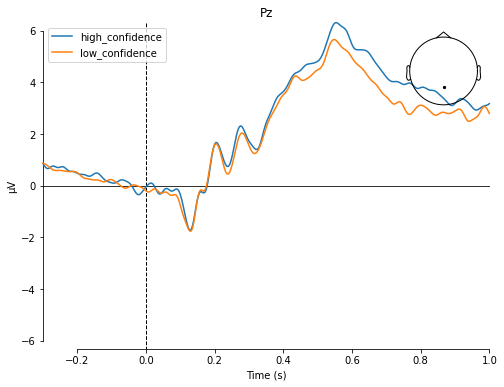

[<Figure size 576x432 with 2 Axes>]

In [90]:
grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = stimulus_epochs['confidence_z_by_participant > 0']
low_conf_epochs = stimulus_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False)


Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"


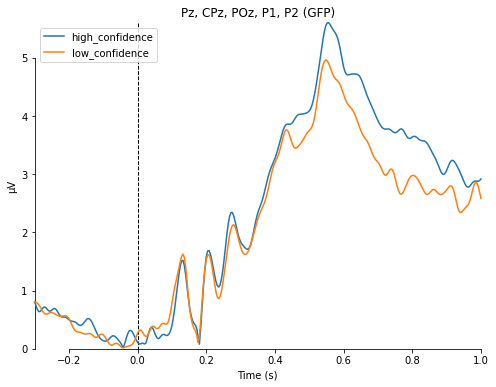

<Figure size 432x288 with 0 Axes>

In [91]:
roi = ["Pz", "CPz", "POz", "P1", "P2"]

grand_average_high_conf = []
grand_average_low_conf = []

high_conf_epochs = stimulus_epochs['confidence_z_by_participant > 0']
low_conf_epochs = stimulus_epochs['confidence_z_by_participant <= 0']


        
for subject in participant_numbers:
    grand_average_high_conf.append(high_conf_epochs['participant == %i' % subject].average())
    grand_average_low_conf.append(low_conf_epochs['participant == %i' % subject].average())


grand_average_high_conf = mne.grand_average(grand_average_high_conf)
grand_average_low_conf = mne.grand_average(grand_average_low_conf)

evokeds = dict(high_confidence=grand_average_high_conf,
               low_confidence=grand_average_low_conf)

mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
plt.savefig('Figures/informational_high_low_conf.pdf', bbox_inches='tight')

## Low vs high confidence split by partner grand average 


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


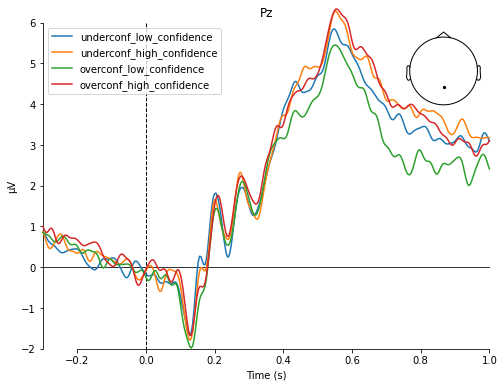

In [30]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

fig = mne.viz.plot_compare_evokeds(evokeds, picks=['Pz'], invert_y=False, ylim=dict(eeg=[-2, 6]))

fig[0].savefig('Figures/informational_high_low_conf_partner_Pz.pdf', bbox_inches='tight')

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


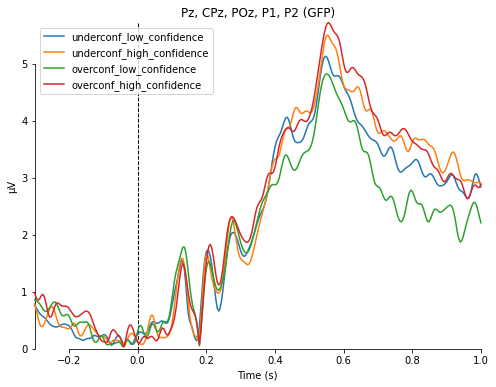

In [95]:
grand_average_underconf_high_conf = []
grand_average_underconf_low_conf = []
grand_average_overconf_high_conf = []
grand_average_overconf_low_conf = []

underconf_epochs = stimulus_epochs['partner == "underconfident"']
underconf_high_conf_epochs = underconf_epochs['confidence_z_by_participant > 0']
underconf_low_conf_epochs = underconf_epochs['confidence_z_by_participant <= 0']

overconf_epochs = stimulus_epochs['partner == "overconfident"']
overconf_high_conf_epochs = overconf_epochs['confidence_z_by_participant > 0']
overconf_low_conf_epochs = overconf_epochs['confidence_z_by_participant <= 0']



for subject in participant_numbers:    
    grand_average_underconf_high_conf.append(underconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_underconf_low_conf.append(underconf_low_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_high_conf.append(overconf_high_conf_epochs['participant == %i' % subject].average())
    grand_average_overconf_low_conf.append(overconf_low_conf_epochs['participant == %i' % subject].average())

grand_average_underconf_high_conf = mne.grand_average(grand_average_underconf_high_conf)
grand_average_underconf_low_conf = mne.grand_average(grand_average_underconf_low_conf)
grand_average_overconf_high_conf = mne.grand_average(grand_average_overconf_high_conf)
grand_average_overconf_low_conf = mne.grand_average(grand_average_overconf_low_conf)


evokeds = dict(underconf_low_confidence=grand_average_underconf_low_conf,
               underconf_high_confidence=grand_average_underconf_high_conf,
               overconf_low_confidence=grand_average_overconf_low_conf,
               overconf_high_confidence=grand_average_overconf_high_conf)

fig = mne.viz.plot_compare_evokeds(evokeds, picks=roi, invert_y=False)
fig[0].savefig('Figures/informational_high_low_conf_partner.pdf', bbox_inches='tight')